# Practice PS07: Outlier analysis

The objective of this session is to practice finding outliers by implementing the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Judith Camacho</font>

E-mail: <font color="blue">judith.camacho01@estudiant.upf.edu</font>

Date: <font color="blue">01/12/2020</font>

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np


# 1. Dataset

We will use the file `thyroid.csv` that contains data about exams of the thyroid gland of 3,772 patients. In each exam, six attributes *f1*, *f2*, ..., *f6* of each patient are measured. A ground-truth label indicating if the thyroid was finally found to be normal or abnormal is included in the dataset. Further information on this dataset can be found in this [free repository](http://odds.cs.stonybrook.edu/thyroid-disease-dataset/).

Leave the loading code below as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [4]:
df = pd.read_csv('thyroid.csv', sep=',')

# Add a patient-id as first column
df['id'] = df.index
df = df[['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'abnormal']]
df['result'] = df['abnormal'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['abnormal'], inplace=True)

# Report
print("Total patients   : %d" % len(df))
print("Normal thyroid   : %d" % len(df[df['result'] == 'normal']))
print("Abnormal thyroid : %d" % len(df[df['result'] == 'abnormal']))
print("Features         : %s" % df.columns)

Total patients   : 3772
Normal thyroid   : 3679
Abnormal thyroid : 93
Features         : Index(['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'result'], dtype='object')


Print the first 10 normal and the first 10 abnormal exams. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [5]:
df_normal = df[df["result"]=="normal"]
df_abnormal = df[df["result"]=="abnormal"]


In [6]:
df_normal.head(10)

,id,f1,f2,f3,f4,f5,f6,result
0,0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,normal
1,1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,normal
2,2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,normal
3,3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,normal
4,4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,normal
5,5,0.731183,0.000472,0.147059,0.196262,0.239437,0.198361,normal
6,6,0.903226,0.000472,0.213472,0.294393,0.399061,0.195082,normal
7,7,0.505376,0.003925,0.185009,0.196262,0.276995,0.177049,normal
8,8,0.709677,0.002453,0.222960,0.198598,0.422535,0.127869,normal
9,9,0.806452,0.000189,0.270398,0.285047,0.511737,0.155738,normal


In [7]:
df_abnormal.head(10)

,id,f1,f2,f3,f4,f5,f6,result
19,19,0.526882,0.115094,0.086338,0.025701,0.455399,0.014754,abnormal
27,27,0.827957,0.047170,0.080645,0.112150,0.305164,0.095082,abnormal
105,105,0.774194,0.088679,0.099620,0.116822,0.333333,0.091803,abnormal
115,115,0.451613,0.132075,0.042694,0.002103,0.399061,0.001311,abnormal
116,116,0.440860,0.058491,0.071157,0.025701,0.469484,0.014754,abnormal
147,147,0.559140,0.047170,0.033207,0.086449,0.197183,0.101639,abnormal
208,208,0.537634,0.045283,0.033207,0.002336,0.375587,0.001639,abnormal
289,289,0.720430,0.049057,0.023719,0.009346,0.286385,0.009180,abnormal
387,387,0.419355,0.079245,0.014231,0.006542,0.333333,0.005574,abnormal
406,406,0.634409,0.015264,0.166034,0.133178,0.361502,0.096721,abnormal


In [8]:
df_normal[["f1","f2", "f3", "f4", "f5", "f6"]].mean()

f1    0.543566
f2    0.004755
f3    0.189353
f4    0.252734
f5    0.376411
f6    0.180496
dtype: float64

In [9]:
df_abnormal[["f1","f2", "f3", "f4", "f5", "f6"]].mean()

f1    0.525494
f2    0.176248
f3    0.086889
f4    0.074221
f5    0.397900
f6    0.050884
dtype: float64

Note that identifying outliers in this dataset is possible because outliers seem to be quite different, across many dimensions, from inliers. To show this, we can create all scatter plots of combinations of two dimensions in the data. In these, you can see that feature values for the minority class (represented by the color red), indeed are quite different from feature values for the majority class (represented by the color blue).

Use [scatter_matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) to create a matrix of scatter plots. The following code creates a simple scatter matrix.

```python
colors = df['result'].apply(lambda x: 'red' if x == 'abnormal' else 'blue' if x == 'normal' else 'black')

pd.plotting.scatter_matrix(df, c=colors)
```

Change the figure size with parameter `figsize` and remove the `id` column.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019449DD3A58>,
      dtype=object)

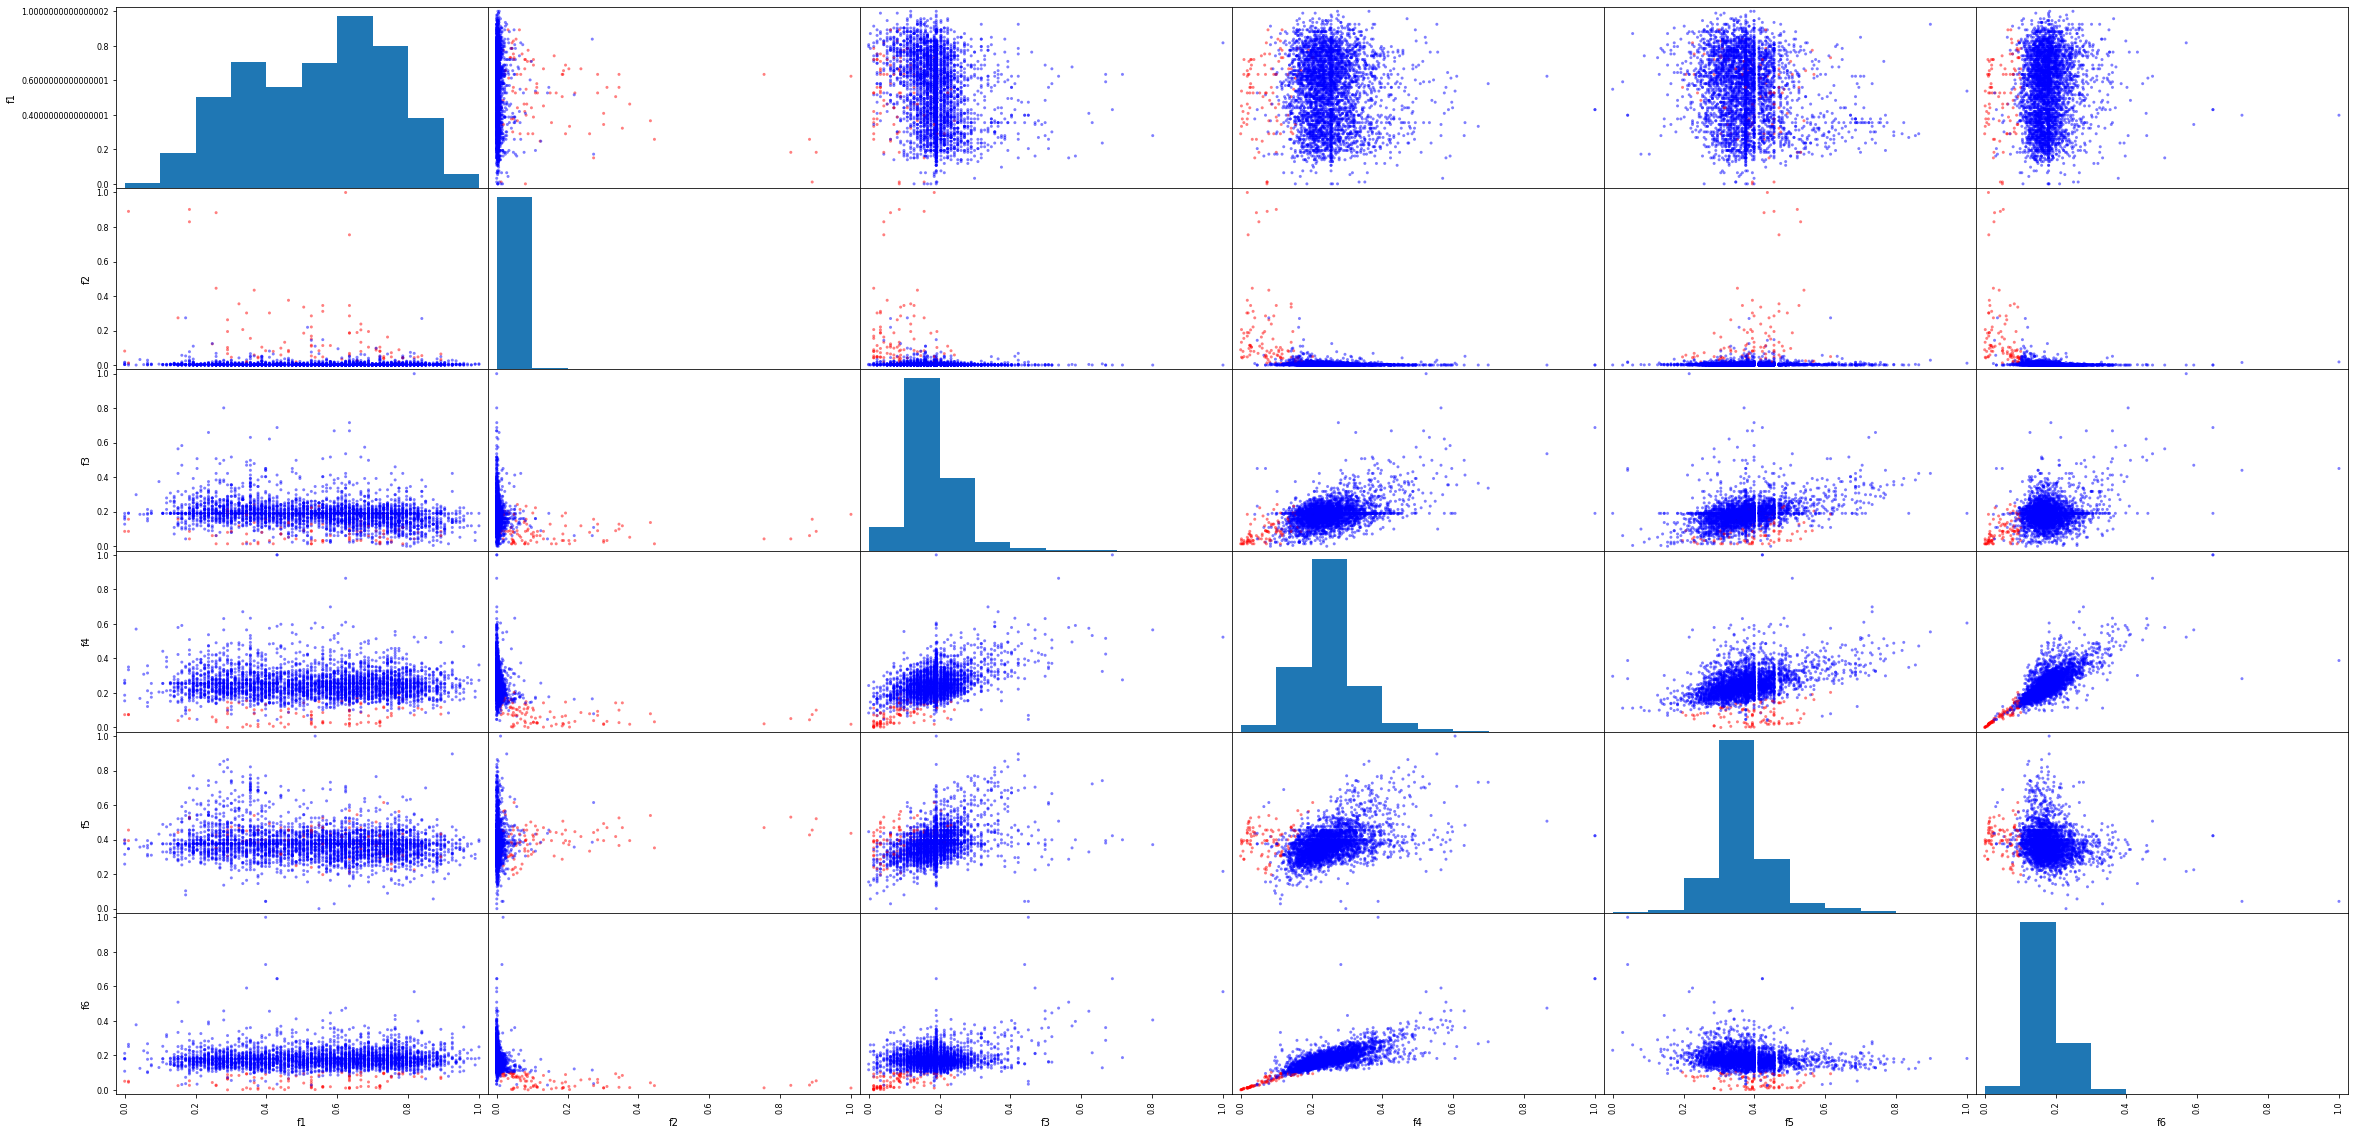

In [10]:
colors = df['result'].apply(lambda x: 'red' if x == 'abnormal' else 'blue' if x == 'normal' else 'black')
pd.plotting.scatter_matrix(df[["f1","f2", "f3", "f4", "f5", "f6", "result"]], c=colors, figsize=(40,20))

There are with difference, more normal exams than abnormal. Also, abnormal are at the very extrems of the values that the normal exams are, so we can consider that outliers are abnormal exams.

# 1. Create isolation tree

## 1.1. Random dimension and random split

Create a function that returns a random dimension in the dataset. We will ignore some columns, because the random dimension can never be *id* or *result*, but instead should be one of the other dimensions 'f1', 'f2', ..., 'f6'. Do not hard-code these dimensions into your function, instead, read df.columns.

The signature of your function should be `pick_random_dimension(df, columns_to_ignore)`.

Test your function by calling it a few times. It should return a random dimension every time.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [11]:
def pick_random_dimension(df, columns_to_ignore):
    columns = df.drop(columns_to_ignore, axis=1).columns
    return columns[random.randint(0, len(columns)-1)]

In [12]:
columns_to_ignore = ["id", "result"]
random_sample1 = pick_random_dimension(df, columns_to_ignore)
random_sample2 = pick_random_dimension(df, columns_to_ignore)


In [13]:
random_sample1

'f1'

In [14]:
random_sample2

'f2'

Create a function that returns a random split point along a dimension. Do not rely on the fact that, *on this dataset* every dimension takes a value between 0.0 and 1.0. Instead, use `np.min(df[dimension])` and `np.max(df[dimension])`.

The signature of your function should be `pick_random_split(df, dimension)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [15]:
def pick_random_split(df, dimension):
    minimum = np.min(df[dimension])
    maximum = np.max(df[dimension])
    return (maximum-minimum)*random.random()+minimum


In [16]:
rand_point1 = pick_random_split(df, "f1")
rand_point2 = pick_random_split(df, "f1")

In [17]:
rand_point1

0.8732718604421079

In [18]:
rand_point2

0.9999650044000792

## 1.2. Implement split data into two

Implement a function `split_dataset(df, dimension, split)` that returns two sub-datasets: one with all elements having *dimension <= split*, and another one with all elements having *dimension > split*.

The signature of your function should be `split_dataset(df, dimension, split)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [19]:
def split_dataset(df, dimension, split):
    left = df[df[dimension]<=split]
    right = df[df[dimension]>split]
    return left, right

Remember to test your function; for instance, split on dimension `f1` at `0.4` by doing:

```python
(left, right) = split_dataset(df, 'f1', 0.4)
```

In the output, all the rows in *left* have *f1 <= 0.4* and all the rows in *right* have *f1 > 0.4*.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [20]:
(left, right) = split_dataset(df, 'f1', 0.4)

In [21]:
left.head(10)

,id,f1,f2,f3,f4,f5,f6,result
1,1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,normal
4,4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,normal
11,11,0.182796,0.000189,0.213472,0.224299,0.309859,0.185246,normal
28,28,0.279570,0.000943,0.118596,0.247664,0.281690,0.221311,normal
30,30,0.290323,0.003566,0.190702,0.255093,0.375587,0.180443,normal
32,32,0.225806,0.000943,0.156546,0.189252,0.314554,0.155738,normal
33,33,0.225806,0.001698,0.232448,0.252336,0.380282,0.177049,normal
34,34,0.344086,0.000755,0.203985,0.205607,0.370892,0.145902,normal
36,36,0.322581,0.000189,0.298861,0.478972,0.647887,0.213115,normal
37,37,0.397849,0.002453,0.260911,0.280374,0.427230,0.178689,normal


In [22]:
right.head(10)

,id,f1,f2,f3,f4,f5,f6,result
0,0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,normal
2,2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,normal
3,3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,normal
5,5,0.731183,0.000472,0.147059,0.196262,0.239437,0.198361,normal
6,6,0.903226,0.000472,0.213472,0.294393,0.399061,0.195082,normal
7,7,0.505376,0.003925,0.185009,0.196262,0.276995,0.177049,normal
8,8,0.709677,0.002453,0.222960,0.198598,0.422535,0.127869,normal
9,9,0.806452,0.000189,0.270398,0.285047,0.511737,0.155738,normal
10,10,0.655914,0.020755,0.071157,0.165888,0.258216,0.157377,normal
12,12,0.623656,0.001509,0.213472,0.214953,0.375587,0.152049,normal


## 1.3. Create one isolation tree

An isolation tree will be a dictionary. In this dictionary, having *contents*, indicates an external node of the tree, while having *left* and *right* indicates an internal node of the tree.

Create a recursive function `isolation_tree(data, columns_to_ignore, min_items)` that:

* If the *data* has *min_items* or less:
    * Return a dictionary `{"contents": data}`
* If the *data* has more than *min_items*
    * Selects a random dimension from the data, ignoring the *columns_to_ignore*
    * Selects a random split point along that dimension
    * Sets `left` to an isolation tree containing points having dimension <= split
    * Sets `right` to an isolation tree containing points having dimension > split
    * Returns a dictionary `{"left": left, "right": right, "dimension": dimension, "split": split}`

You can use the following skeleton:

```python
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        # REPLACE WITH YOUR CODE 
        return tree   
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [23]:
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        random_dimension = pick_random_dimension(data, columns_to_ignore)
        split = pick_random_split(data, random_dimension)
        (left, right) = split_dataset(data, random_dimension, split)
        tree = {
            "left": isolation_tree(left, columns_to_ignore, min_items),
            "right": isolation_tree(right, columns_to_ignore, min_items), 
            "dimension": random_dimension, 
            "split": split
        }
        return tree   

Test your function creating a shallow tree.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [24]:
mytree = isolation_tree(df, ['id', 'result'], 500)

You do not need to modify the next function, which is useful to print a tree in ASCII.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [25]:
class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("L", level+1)
        if self.right:
            ret += self.right.__str__("R", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "%d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = tree['dimension'] + '<=' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

Print your tree using this function. Given that the tree is created by a randomized process, your tree will look different from this one.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [26]:
print(tree_to_nodes(mytree))

:'f6<=0.99'
-L:'f2<=0.36'
--L:'f2<=0.29'
---L:'f4<=0.97'
----L:'f3<=0.54'
-----L:'f5<=0.27'
------L:'239 normal + 8 abnormal'
------R:'f3<=0.07'
-------L:'80 normal + 30 abnormal'
-------R:'f4<=0.58'
--------L:'f6<=0.42'
---------L:'f6<=0.07'
----------L:'10 normal + 17 abnormal'
----------R:'f4<=0.24'
-----------L:'f6<=0.17'
------------L:'f2<=0.15'
-------------L:'f1<=0.57'
--------------L:'f5<=0.50'
---------------L:'f6<=0.15'
----------------L:'321 normal + 7 abnormal'
----------------R:'276 normal + 0 abnormal'
---------------R:'7 normal + 0 abnormal'
--------------R:'f4<=0.11'
---------------L:'1 normal + 3 abnormal'
---------------R:'f3<=0.09'
----------------L:'9 normal + 2 abnormal'
----------------R:'f3<=0.25'
-----------------L:'f6<=0.12'
------------------L:'59 normal + 9 abnormal'
------------------R:'460 normal + 0 abnormal'
-----------------R:'15 normal + 0 abnormal'
-------------R:'1 normal + 1 abnormal'
------------R:'326 normal + 0 abnormal'
-----------R:'f6<=0.41'
--

# 2. Create isolation forests and find depth of items

An isolation forest will be simply a an array of isolation trees.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 2.1. Create an isolation forest

Write a function `isolation_forest(df, columns_to_ignore, min_items, num_trees)` that creates an array of *num_trees* isolation trees.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [27]:
def isolation_forest(df, columns_to_ignore, min_items, num_trees):
    return [
        isolation_tree(df, columns_to_ignore, min_items)  
        for _ in range(num_trees) 
    ]

Use the next code to test how to create an isolation forest of 20 trees, in which leaves have at least 10 items. It might take a few minutes to run.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [28]:
min_items = 10
num_trees = 20
myforest = isolation_forest(df, ['id', 'result'], min_items, num_trees)

print("The forest has %d trees" % len(myforest))

The forest has 20 trees


## 2.2. Find the average depth of an item

Thie function `find_element_depth` finds the depth of a given element by recursively traversing the tree. It is a complicated function so we provide it. You can leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [29]:
def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

Test this function by running it to find 10 normal and 10 abnormal thyroid exams on the singe tree `mytree` that we created above.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


In [30]:
for result in ['normal', 'abnormal']:
    print("Depths for %s items" % result)
    
    sample = list(df[df['result'] == result]['id'].sample(10))

    for random_id in sample:
        print("- id=%d is at depth %d" % (random_id, find_element_depth(mytree, "id", random_id)))

Depths for normal items
- id=1937 is at depth 22
- id=2712 is at depth 12
- id=1820 is at depth 18
- id=103 is at depth 19
- id=1054 is at depth 22
- id=575 is at depth 23
- id=2913 is at depth 26
- id=1101 is at depth 6
- id=732 is at depth 18
- id=2586 is at depth 22
Depths for abnormal items
- id=2601 is at depth 3
- id=1468 is at depth 7
- id=3429 is at depth 6
- id=429 is at depth 18
- id=1633 is at depth 7
- id=3679 is at depth 7
- id=3625 is at depth 7
- id=3565 is at depth 6
- id=1620 is at depth 2
- id=1209 is at depth 16


Abnormal items are found with just one call, because they are far from the others so they get to be isolateed in less steps than normal observations. 

Write function `find_average_depth(forest, column_name, value)` that finds the the average depth of an element having *column_name = value*

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


In [31]:
def find_average_depth(forest, column_name, value):
    depths = []
    for tree in forest:
        depth = find_element_depth(tree, column_name, value)
        depths.append(depth)
    return np.mean(depths)

Test this function with some random elements.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [32]:
for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)
    
    sample = list(df[df['result'] == result]['id'].sample(10))
    
    for random_id in sample:
        print("- id=%d is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))


Average depths for normal items
- id=2602 is at average depth 15.4
- id=1302 is at average depth 25.1
- id=1300 is at average depth 31.9
- id=1439 is at average depth 15.8
- id=225 is at average depth 26.5
- id=1242 is at average depth 27.8
- id=944 is at average depth 49.7
- id=1411 is at average depth 22.4
- id=2401 is at average depth 23.6
- id=3542 is at average depth 18.6
Average depths for abnormal items
- id=838 is at average depth 11.3
- id=639 is at average depth 14.1
- id=289 is at average depth 10.8
- id=1882 is at average depth 6.0
- id=794 is at average depth 12.8
- id=544 is at average depth 13.9
- id=1057 is at average depth 14.2
- id=3625 is at average depth 11.9
- id=600 is at average depth 12.3
- id=2209 is at average depth 6.2


To make it more efficient, I would look for the average depth for all elements at the same time. This way I won't be exploring the same branches multiple times, so I will be exploring each opened branch only once. To build the function, instead of "find_average_depth(forest, column_name, value)", it will be "find_average_depths(forest, column_name, values)" and it will be a list of values.

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

Next we sample 50 normal and 50 abnormal points, and store their average depths in `myforest` into arrays `normal_depths` and `abnormal_depths`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [33]:
abnormal_point_ids = list(df[df['result'] == 'abnormal']['id'].sample(50))
normal_point_ids = list(df[df['result'] == 'normal']['id'].sample(50))

print("Normal point ids   : %s" % normal_point_ids)
print("Abnormal point ids : %s" % abnormal_point_ids)

Normal point ids   : [2919, 1725, 2345, 694, 1015, 1540, 2958, 810, 1445, 2930, 1260, 1958, 2378, 783, 2828, 626, 2917, 1514, 2925, 2102, 2607, 2582, 2037, 1857, 248, 919, 3480, 280, 1704, 817, 3405, 432, 3302, 3649, 3578, 852, 2154, 811, 1804, 1765, 1453, 1273, 2257, 106, 722, 2556, 2413, 2626, 2557, 1507]
Abnormal point ids : [838, 2374, 2503, 3565, 2631, 3275, 1209, 1227, 544, 147, 1040, 3147, 116, 686, 1275, 3625, 3589, 2075, 406, 3429, 519, 2601, 1808, 794, 1777, 1916, 2728, 19, 1790, 2588, 1500, 3512, 1620, 2628, 2339, 3679, 1853, 2931, 1867, 517, 2945, 2774, 429, 2937, 1468, 1836, 2515, 860, 964, 2702]


In [34]:
normal_depths = []
print("Normal items:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%d is at average depth %.2f" % (i, depth))

Normal items:
 element id=2919 is at average depth 11.50
 element id=1725 is at average depth 17.05
 element id=2345 is at average depth 12.45
 element id=694 is at average depth 21.25
 element id=1015 is at average depth 26.80
 element id=1540 is at average depth 21.55
 element id=2958 is at average depth 26.80
 element id=810 is at average depth 24.60
 element id=1445 is at average depth 20.10
 element id=2930 is at average depth 22.60
 element id=1260 is at average depth 24.85
 element id=1958 is at average depth 25.60
 element id=2378 is at average depth 26.55
 element id=783 is at average depth 18.50
 element id=2828 is at average depth 21.40
 element id=626 is at average depth 25.45
 element id=2917 is at average depth 26.90
 element id=1514 is at average depth 17.00
 element id=2925 is at average depth 22.25
 element id=2102 is at average depth 22.90
 element id=2607 is at average depth 28.50
 element id=2582 is at average depth 21.70
 element id=2037 is at average depth 24.25
 

In [35]:
abnormal_depths = []
print("Abormal items:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%d is at average depth %.2f" % (i, depth))

Abormal items:
 element id=838 is at average depth 11.30
 element id=2374 is at average depth 13.65
 element id=2503 is at average depth 4.70
 element id=3565 is at average depth 13.25
 element id=2631 is at average depth 13.60
 element id=3275 is at average depth 9.35
 element id=1209 is at average depth 12.60
 element id=1227 is at average depth 10.05
 element id=544 is at average depth 13.95
 element id=147 is at average depth 13.85
 element id=1040 is at average depth 11.95
 element id=3147 is at average depth 8.05
 element id=116 is at average depth 11.45
 element id=686 is at average depth 10.85
 element id=1275 is at average depth 9.80
 element id=3625 is at average depth 11.95
 element id=3589 is at average depth 13.95
 element id=2075 is at average depth 12.40
 element id=406 is at average depth 18.25
 element id=3429 is at average depth 12.25
 element id=519 is at average depth 16.10
 element id=2601 is at average depth 9.50
 element id=1808 is at average depth 8.60
 element 

Now, we create an histogram of the depths of normal and abnormal items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

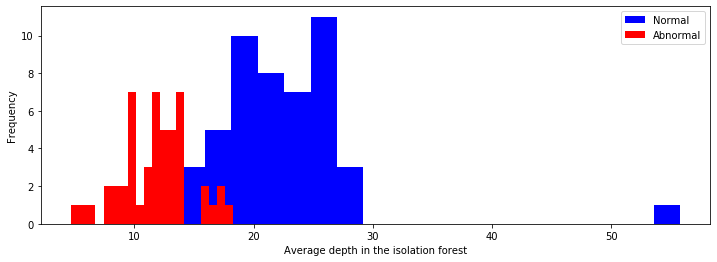

In [36]:
plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can see two normal distributions, one for normal diagnosis and another for abnormals. In addition, we can see some extreme values of the right, are normal. They are so far because they are at a higher depth, so according the theory of Isolation Trees, they are normal diagnosis and not abnormal (abnormals or outliers are found with just one call). 


## 3.2. Compute outlier scores and conclude

Use this fast method to compute harmonic numbers. Leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [37]:
# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

With this and the formula seen in class, you can compute outlier scores. The function below, which you should leave as-is, uses the *factory* design pattern to avoid computing *c(n)* every time the outlier score needs to be computed.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [38]:
def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

Finally, we plot an histogram of outlier scores of normal and abnormal items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

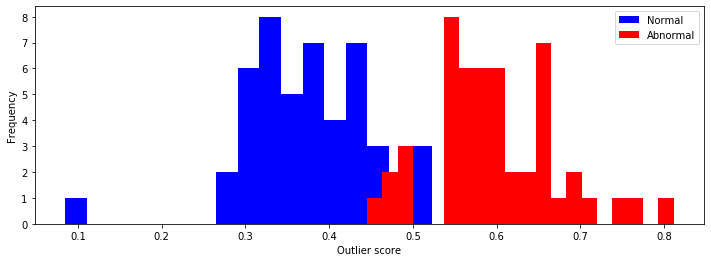

In [39]:
plt.figure(figsize=(12,4))
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Abnormal items have higher outlier scores. 

Next, write code to determine an optimal outlier score threshold based on `normal_scores` and `abnormal_scores` assuming every thyroid exam having *score <= threshold* will be classified as abnormal, and every thyroid exam with score > threshold will be classified as normal.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [90]:
# returns the % of good classified. It is to get the accuracy
def correctly_classified(normal_scores, abnormal_scores, threshold):
    correct_normal = sum(map(lambda x: x <=threshold, normal_scores))
    correct_abnormal = sum(map(lambda x: x > threshold, abnormal_scores))
    return ((correct_normal + correct_abnormal) / (len(normal_scores)+ len(abnormal_scores)))

def binary_find_threshold(normal_scores, abnormal_scores, low, high, accuracy):
    #calculate mid
    mid = (high + low)/2
    #store accuracy
    old_accuracy = accuracy
    
    #re-calculate accuracy
    accuracy = correctly_classified(normal_scores, abnormal_scores, mid)    
    #if the new accuracy is better, keep searching for a even better one
    if(accuracy > old_accuracy):
        #recompute accuracy and new mid: will be the max of the following
        accuracy, mid = max([
            #search int the first half
            find_threshold(normal_scores, abnormal_scores, low, mid, accuracy),
            #search in the second half
            find_threshold(normal_scores, abnormal_scores, mid, high, accuracy),
            # the last accuracy
            (accuracy, mid)], key=lambda x: x[0]
        )
    
    return accuracy, mid

def get_threshold(normal_scores, abnormal_scores):
    low = min(normal_scores + abnormal_scores)
    high = max(normal_scores + abnormal_scores)
    accuracy, threshold =binary_find_threshold(normal_scores, abnormal_scores, low, high, 0)
    print(f"The best thershold is {threshold} with {accuracy*100:.9f}%")
    return threshold
  

Evaluate the threshold you have found. We know results will not be perfect as in this dataset there are some normal exams that look like abnormal and viceversa. If you use this threshold, indicate what is the estimated false positive rate (the probability of saying that a thyroid is abnormal when it is normal), and false negative rate (the probability of saying that a thyroid is normal when it is abnormal).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [89]:
get_threshold(normal_scores, abnormal_scores)

The best thershold is 0.4480655605204457 with 89.000000000%


0.4480655605204457

I think my function finds a good threshold. The threshold could possibly be 0.44. For me such a value makes sense: in the above plot, we can see the first abnormal bar is at 0.4-0.5. There are some more bars after and between 0.5 and 0.6; there are only blue bars after these first red bars.
It is like there are more abnormals within the range of normals, than normals at the range of abnormal. Hence, for me it makes sense that the threshold is at 0.44 instead that at 0.51.

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, implement a faster method for finding_average_depths, indicating in your report that you implemented a faster method. Then, in the histograms do not sample but instead use all the elements in the dataset, i.e., remove `.sample(...)`.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: faster method to find all depths</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>